# Data import and preprocessing

## Libraries Import

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime

In [2]:
import parser_1

## Feature Extraction Leveraging Domain Knowledge

In [3]:
severity_dict = {
    "emerg": 0,
    "alert": 1,
    "crit": 2,
    "error": 3,
    "warn": 4,
    "notice": 5,
    "info": 6,
    "debug": 7
}

facility_dict = {
    "kern": 0,
    "user": 1,
    "mail": 2,
    "system": 3, # system = system daemon
    "auth": 4,
    "<syslog?>": 5,
    "<line printer?>": 6,
    "news": 7,
    "uucp": 8,
    "clock": 9, # questo è cron
    "authpriv": 10,
    "ftp": 11,
    "ntp": 12,
    "<log audit?>": 13,
    "<log alert?>": 14,
    "cron":15, # ipotizzando che cron stia usando 15
    "local0": 16,
    "local1": 17,
    "local2": 18,
    "local3": 19,
    "local4": 20,
    "local5": 21,
    "local6": 22,
    "local7": 23,
    "daemon": 22 # ipotizzando che laurel stia usando local6
}

In [4]:
# general log preprocessing analysis for each type of log
log_types = ['cron', 'laurel', 'maillog', 'messages', 'secure', 'user']
file_paths = ['sample_logs_' + logtype + '.txt' for logtype in log_types]

print(file_paths)

# Severity normal level (established arbitrarily)
normal_level = "info"
normal_level_numerical = severity_dict[normal_level]

df_list = []

for file_path in file_paths:
    df = parser_1.parse_file_to_df(file_path)
    # Create severity and facility ID numbers for each dataframe
    df['severity_numbers'] = [severity_dict[elem] for elem in df['severity']]
    df['facility_numbers'] = [facility_dict[elem] for elem in df['facility']]
    # Create severity scores
    df['severity_scores'] = [np.exp(normal_level_numerical-elem) for elem in df['severity_numbers']]
    # Append time deltas
    timedeltas = []
    for i, date_str in enumerate(df['time']):
        if i == 0:
            timedeltas.append(0)
        else:
            date = datetime.strptime(date_str, '%Y-%m-%d %H:%M:%S %z')
            date_prev = datetime.strptime(df['time'][i-1], '%Y-%m-%d %H:%M:%S %z')
            timedelta = date - date_prev
            timedeltas.append(timedelta.total_seconds())

    df['timedelta'] = timedeltas
    df_list.append(df)

['sample_logs_cron.txt', 'sample_logs_laurel.txt', 'sample_logs_maillog.txt', 'sample_logs_messages.txt', 'sample_logs_secure.txt', 'sample_logs_user.txt']


In [5]:
import preprocess

In [6]:
# Now for each log report type we need to call the appropriate preprocessing function
# Dataframes are contained in df_list
# Names of log types are containes in log_types

def get_function(log_type):
    switcher = {
        "cron": preprocess.preprocess_message_cron,
        "laurel": preprocess.preprocess_message_laurel,
        "maillog": preprocess.preprocess_message_maillog,
        "messages": preprocess.preprocess_message_messages,
        "secure": preprocess.preprocess_message_secure,
        "user": preprocess.preprocess_message_user
    }

    return switcher.get(log_type, "Invalid Log Type")

In [7]:
for i, df in enumerate(df_list):
    func = get_function(log_types[i])
    df = func(df)

In [8]:
for i, df in enumerate(df_list):
    print('==============')
    print(log_types[i])
    print(df.columns)

cron
Index(['host', 'ident', 'pid', 'message', 'severity', 'facility', 'time',
       'severity_numbers', 'facility_numbers', 'severity_scores', 'timedelta',
       'user', 'common_file_paths_length'],
      dtype='object')
laurel
Index(['host', 'ident', 'message', 'severity', 'facility', 'time',
       'severity_numbers', 'facility_numbers', 'severity_scores', 'timedelta',
       'suid'],
      dtype='object')
maillog
Index(['host', 'ident', 'pid', 'message', 'severity', 'facility', 'time',
       'severity_numbers', 'facility_numbers', 'severity_scores', 'timedelta'],
      dtype='object')
messages
Index(['host', 'ident', 'pid', 'message', 'severity', 'facility', 'time',
       'severity_numbers', 'facility_numbers', 'severity_scores', 'timedelta'],
      dtype='object')
secure
Index(['host', 'ident', 'pid', 'message', 'severity', 'facility', 'time',
       'severity_numbers', 'facility_numbers', 'severity_scores', 'timedelta'],
      dtype='object')
user
Index(['host', 'ident', 'pid

In [9]:
df_list[1]['suid']

0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    0
8    0
9    0
Name: suid, dtype: int64

One-Hot Encoding

In [10]:
columns_to_drop = ['message', 'severity', 'facility', 'time' ,'severity_numbers']
columns_to_encode =['host', 'ident', 'pid', 'facility_numbers', 'user']

encoded_df_list = []

for i,df in enumerate(df_list):
    #print('================')
    for col in columns_to_drop:
        try:
            #print(f'removed {col} from df {i}')
            df = df.drop(columns=col)
            #print(f'shape {df.shape}')
        except:
            pass
        
    for col in columns_to_encode:
        try:
            df = pd.get_dummies(df, columns=[col])
            #print(f'encoded {col} from df {i}')
        except:
            pass
        
        #print(f'shape {df.shape}')
        
    encoded_df_list.append(df)

In [15]:
encoded_df_list[0]

,severity_scores,timedelta,common_file_paths_length,host_login01,ident_CROND,pid_15498,pid_25104,pid_25122,pid_25123,pid_44373,...,pid_8705,pid_8713,pid_8714,pid_8715,pid_8716,pid_8717,facility_numbers_15,user_a07cmc01,user_acctdata,user_root
0,1.0,0.0,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
1,1.0,0.0,2,1,1,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
2,1.0,0.0,3,1,1,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
3,1.0,0.0,3,1,1,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
4,1.0,0.0,2,1,1,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
5,1.0,1200.0,1,1,1,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,1
6,1.0,0.0,3,1,1,0,0,1,0,0,...,0,0,0,0,0,0,1,1,0,0
7,1.0,0.0,3,1,1,0,0,0,1,0,...,0,0,0,0,0,0,1,1,0,0
8,1.0,300.0,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
9,1.0,0.0,3,1,1,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0


In [12]:
df_list[0].columns
#cat_cols.append(['host', 'ident', 'facility_numbers', 'severity_scores', 'suid'])

Index(['host', 'ident', 'pid', 'message', 'severity', 'facility', 'time',
       'severity_numbers', 'facility_numbers', 'severity_scores', 'timedelta',
       'user', 'common_file_paths_length'],
      dtype='object')

In [13]:
df_list[0].columns

Index(['host', 'ident', 'pid', 'message', 'severity', 'facility', 'time',
       'severity_numbers', 'facility_numbers', 'severity_scores', 'timedelta',
       'user', 'common_file_paths_length'],
      dtype='object')

In [20]:
target_df = df_list[0]
target_df = target_df.drop(columns=['message', 'severity', 'facility', 'time' ,'severity_numbers'])
target_df.columns

Index(['host', 'ident', 'pid', 'facility_numbers', 'severity_scores',
       'timedelta', 'user', 'common_file_paths_length'],
      dtype='object')

In [21]:
columns_to_encode = ['host', 'ident', 'pid', 'facility_numbers', 'user']
target_df = pd.get_dummies(target_df, columns=columns_to_encode)
print(target_df)

    severity_scores  timedelta  common_file_paths_length  host_login01  \
0               1.0        0.0                         1             1   
1               1.0        0.0                         2             1   
2               1.0        0.0                         3             1   
3               1.0        0.0                         3             1   
4               1.0        0.0                         2             1   
5               1.0     1200.0                         1             1   
6               1.0        0.0                         3             1   
7               1.0        0.0                         3             1   
8               1.0      300.0                         1             1   
9               1.0        0.0                         3             1   
10              1.0      300.0                         1             1   
11              1.0        1.0                         3             1   
12              1.0        0.0        

# Anomaly Detection

## Dimensionality reduction

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

### PCA

In [26]:
# Create a sample DataFrame (replace this with your actual DataFrame)
data = target_df

# Perform PCA
pca = PCA()
pca.fit(data)

# Transform the data to principal componentsa
transformed_data = pca.transform(data)

In [ ]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(transformed_data[:, 0], transformed_data[:, 1], transformed_data[:, 2], s=50)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

plt.title('Scatter Plot along the first 3 PCs')
plt.show()

In [ ]:
# Plot the cumulative explained variance
plt.subplot(1, 2, 2)
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance')
plt.grid(True)

plt.tight_layout()
plt.show()


### tSNE

In [ ]:
from sklearn.manifold import TSNE

# Perform t-SNE decomposition
tsne = TSNE(n_components=3)  # Set the number of components to 3 for 3D visualization
tsne_components = tsne.fit_transform(data)

# Plotting scatter plot along the t-SNE components
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(tsne_components[:, 0], tsne_components[:, 1], tsne_components[:, 2], s=50)

ax.set_xlabel('t-SNE Component 1')
ax.set_ylabel('t-SNE Component 2')
ax.set_zlabel('t-SNE Component 3')

plt.title('Scatter Plot along t-SNE Components')
plt.show()


### UMAP

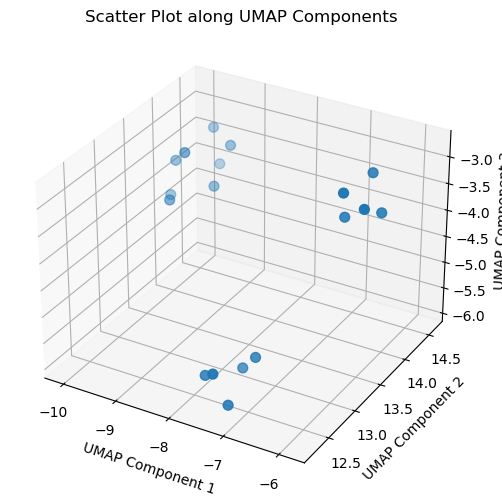

In [27]:
import umap

# Perform UMAP decomposition
umap_emb = umap.UMAP(n_components=3)  # Set the number of components to 3 for 3D visualization
umap_components = umap_emb.fit_transform(data)

# Plotting scatter plot along the UMAP components
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(umap_components[:, 0], umap_components[:, 1], umap_components[:, 2], s=50)

ax.set_xlabel('UMAP Component 1')
ax.set_ylabel('UMAP Component 2')
ax.set_zlabel('UMAP Component 3')

plt.title('Scatter Plot along UMAP Components')
plt.show()


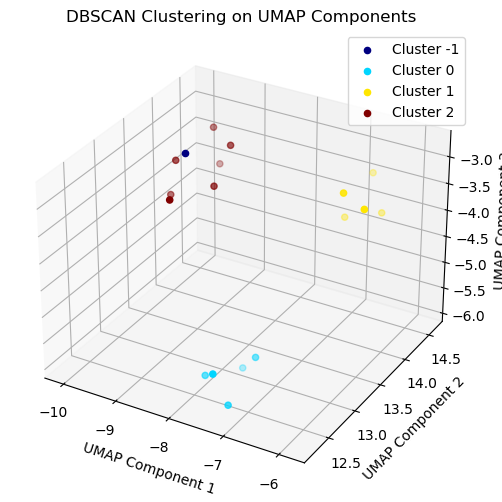

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from mpl_toolkits.mplot3d import Axes3D

# Perform DBSCAN clustering
dbscan = DBSCAN(eps=0.7, min_samples=3)
labels = dbscan.fit_predict(umap_components)

# Plotting scatter plot along the UMAP components with different colors for clusters
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Visualizing each cluster with a different color
unique_labels = np.unique(labels)
colors = plt.cm.jet(np.linspace(0, 1, len(unique_labels)))
for label, color in zip(unique_labels, colors):
    cluster_data = umap_components[labels == label]
    ax.scatter(cluster_data[:, 0], cluster_data[:, 1], cluster_data[:, 2], c=[color], label=f'Cluster {label}')

ax.set_xlabel('UMAP Component 1')
ax.set_ylabel('UMAP Component 2')
ax.set_zlabel('UMAP Component 3')

plt.title('DBSCAN Clustering on UMAP Components')
plt.legend()
plt.show()


In [29]:
target_df['labels'] = labels
target_df

,severity_scores,timedelta,common_file_paths_length,host_login01,ident_CROND,pid_15498,pid_25104,pid_25122,pid_25123,pid_44373,...,pid_8713,pid_8714,pid_8715,pid_8716,pid_8717,facility_numbers_15,user_a07cmc01,user_acctdata,user_root,labels
0,1.0,0.0,1,1,1,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
1,1.0,0.0,2,1,1,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0
2,1.0,0.0,3,1,1,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,2
3,1.0,0.0,3,1,1,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,-1
4,1.0,0.0,2,1,1,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0
5,1.0,1200.0,1,1,1,0,1,0,0,0,...,0,0,0,0,0,1,0,0,1,1
6,1.0,0.0,3,1,1,0,0,1,0,0,...,0,0,0,0,0,1,1,0,0,2
7,1.0,0.0,3,1,1,0,0,0,1,0,...,0,0,0,0,0,1,1,0,0,2
8,1.0,300.0,1,1,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,1
9,1.0,0.0,3,1,1,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,2
